In [39]:
import pandas as pd
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree as plot_sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [33]:
# Entropia
def entropy(data):
    labels = data.iloc[:, -1]
    total = len(labels)
    counts = Counter(labels)
    return -sum((count / total) * math.log2(count / total) for count in counts.values())

def split_dataset(data, feature, value, continuous=False):
    if continuous:
        left = data[data[feature] <= value].copy()
        right = data[data[feature] > value].copy()
    else:
        left = data[data[feature] == value].copy()
        right = data[data[feature] != value].copy()
    return left, right

def information_gain_categorical(data, feature):
    base_entropy = entropy(data)
    values = data[feature].unique()
    weighted_entropy = 0

    for value in values:
        subset = data[data[feature] == value]
        weighted_entropy += (len(subset) / len(data)) * entropy(subset)
        
    return base_entropy - weighted_entropy

def information_gain_continuous(data, feature):
    base_entropy = entropy(data)
    values = data[feature].sort_values().unique()
    best_gain = 0
    best_threshold = None

    for i in range(1, len(values)):
        threshold = (values[i - 1] + values[i]) / 2
        left, right = split_dataset(data, feature, threshold, continuous=True)
        
        if len(left) == 0 or len(right) == 0:
            continue

        weighted_entropy = (len(left) / len(data)) * entropy(left) + \
                           (len(right) / len(data)) * entropy(right)
        gain = base_entropy - weighted_entropy

        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold
    
    return best_gain, best_threshold

In [34]:
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, result=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.result = result 


def id3(data, features, max_depth=None, depth=0):
    labels = data.iloc[:, -1]

    # Caso 1: Todas as instâncias têm a mesma classe
    if len(set(labels)) == 1:
        return DecisionNode(result=labels.iloc[0])

    # Caso 2: Não há mais atributos para dividir
    if len(features) == 0 or (max_depth is not None and depth >= max_depth):
        return DecisionNode(result=labels.mode()[0])

    # Encontrar o melhor atributo para dividir
    best_gain = 0
    best_feature = None
    best_threshold = None
    is_continuous = False

    for feature in features:
        if np.issubdtype(data[feature].dtype, np.number):  # Atributos contínuos
            gain, threshold = information_gain_continuous(data, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
                is_continuous = True
        else:  # Atributos categóricos
            gain = information_gain_categorical(data, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = None
                is_continuous = False

    if best_gain == 0:
        return DecisionNode(result=labels.mode()[0])

    # Dividir os dados com base no melhor atributo
    features = [f for f in features if f != best_feature]
    left, right = split_dataset(data, best_feature, best_threshold, is_continuous)

    # Criar os nós da árvore
    return DecisionNode(
        feature=best_feature,
        threshold=best_threshold if is_continuous else None,
        left=id3(left, features, max_depth, depth + 1),
        right=id3(right, features, max_depth, depth + 1)
    )


# Função para classificar novas instâncias
def classify(node, row):
    while node.result is None:
        val = row[node.feature]
        if node.threshold is not None:
            node = node.left if val <= node.threshold else node.right
        else:
            node = node.left if val == row[node.feature] else node.right
    return node.result

In [ ]:
# Carregar os dados
df = pd.read_csv("iris.csv")
df = df.drop(columns=["ID"])

# Construir a árvore
features = df.columns[:-1]
X = df[features]
y = df['class']
tree = id3(df, features)

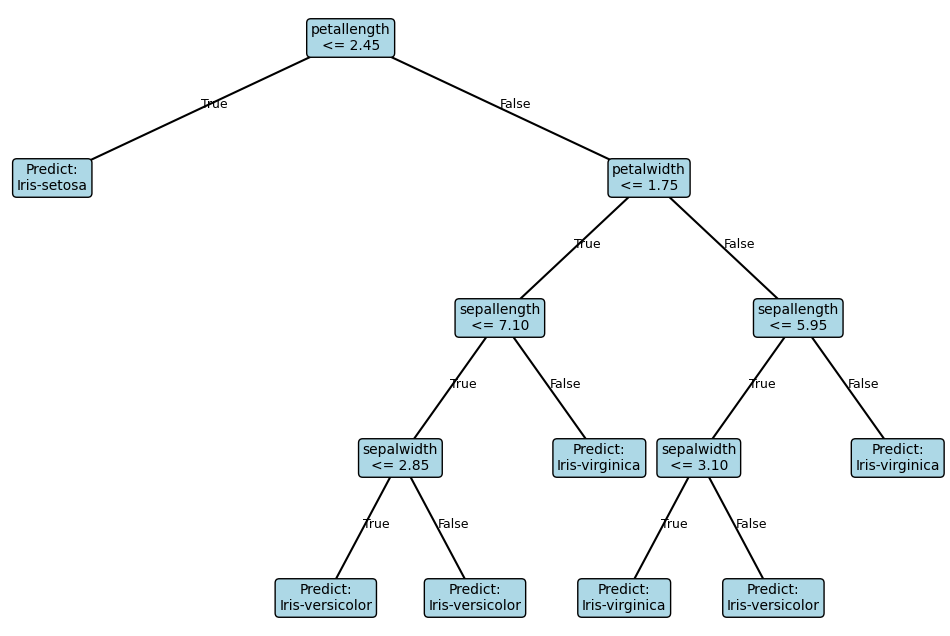

In [36]:
def plot_tree(node, depth=0, x=0.5, y=1.0, dx=0.2, ax=None, parent_pos=None, label=''):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_axis_off()

    # Texto do nó
    if node.result is not None:
        text = f'Predict:\n{node.result}'
    elif node.threshold is not None:
        text = f'{node.feature}\n<= {node.threshold:.2f}'
    else:
        text = f'{node.feature}'

    # Desenhar este nó
    ax.text(x, y, text, ha='center', va='center',
            bbox=dict(boxstyle="round", facecolor='lightblue'))

    # Linha para o nó pai
    if parent_pos is not None:
        ax.plot([parent_pos[0], x], [parent_pos[1], y], 'k-')
        mx, my = (parent_pos[0] + x)/2, (parent_pos[1] + y)/2
        ax.text(mx, my, label, fontsize=9)

    # Recuo vertical e horizontal
    if node.left:
        plot_tree(node.left, depth + 1, x - dx/(depth+1), y - 0.15, dx, ax, (x, y), 'True')
    if node.right:
        plot_tree(node.right, depth + 1, x + dx/(depth+1), y - 0.15, dx, ax, (x, y), 'False')

    if depth == 0:
        plt.show()





plot_tree(tree)

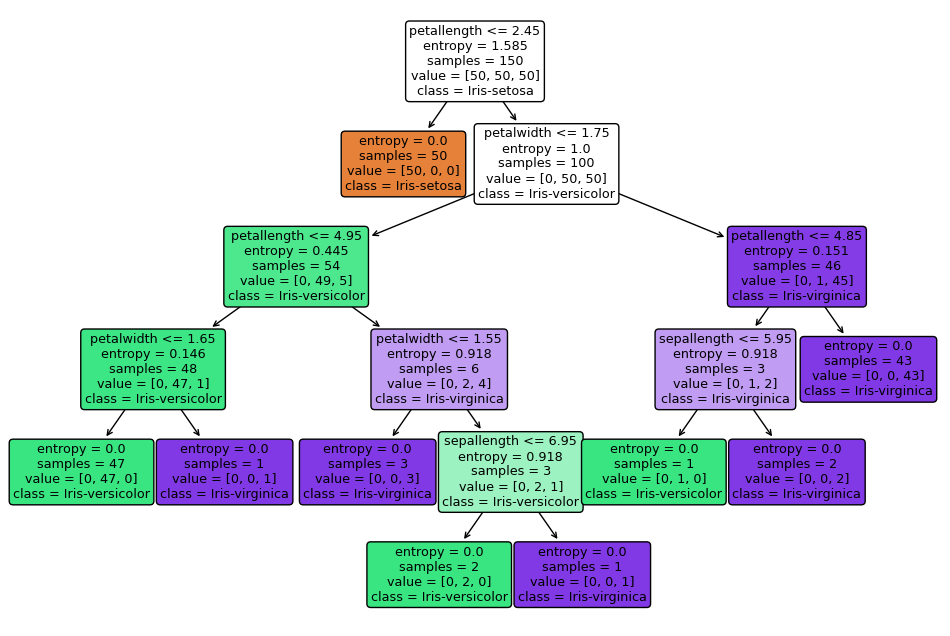

In [37]:
# Separar as features e o target
X = df.iloc[:, :-1]  # Features (atributos)
y = df.iloc[:, -1]   # Target (classe)

# Construir a árvore de decisão com sklearn
tree_sk = DecisionTreeClassifier(criterion='entropy')  # Usando entropia como critério
tree_sk.fit(X, y)

plt.figure(figsize=(12, 8))
plot_sk(tree_sk, filled=True, feature_names=X.columns, class_names=y.unique(), rounded=True)
plt.show()

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
tree_id3 = id3(train_data, X_train.columns)

def predict_id3(tree, X_test):
    predictions = []
    for _, row in X_test.iterrows():
        predictions.append(classify(tree, row))
    return predictions

y_pred_id3 = predict_id3(tree_id3, X_test)

tree_sk = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_sk.fit(X_train, y_train)

y_pred_sk = tree_sk.predict(X_test)

accuracy_id3 = accuracy_score(y_test, y_pred_id3)
print("Accuracy da árvore ID3:", accuracy_id3)

accuracy_sk = accuracy_score(y_test, y_pred_sk)
print("Accuracy da árvore do scikit-learn:", accuracy_sk)

print("\nRelatório de Performance - Árvore ID3:")
print(classification_report(y_test, y_pred_id3))

print("\nRelatório de Performance - Árvore do scikit-learn:")
print(classification_report(y_test, y_pred_sk))

print("\nMatriz de Confusão - Árvore ID3:")
print(confusion_matrix(y_test, y_pred_id3))

print("\nMatriz de Confusão - Árvore do scikit-learn:")
print(confusion_matrix(y_test, y_pred_sk))

Acurácia da árvore ID3: 1.0
Acurácia da árvore do scikit-learn: 0.9777777777777777

Relatório de Performance - Árvore ID3:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45


Relatório de Performance - Árvore do scikit-learn:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       0.93      1.00      0.96        13
 Iris-virginica       1.00      0.92      0.96        13

       accuracy                           0.98        45
      macro avg       0.98      0.97      0.97        45
   weighted avg       0.98      0.98      0.98        45


Matriz de Confusão -